# Brief summary of Cross-Asset Skew strategy

Strategy ([Nick Baltas et al 2019](https://www.researchgate.net/publication/338498916_Cross-Asset_Skew)): Calculate rolling (256 trading days = 1 trading year) skew of assets (here ETFs) in different asset classes (here Commodities, Equities and Fixed Income), rank them based on their skewness within each asset class and assign weights based on the rank (from low to high skewness). Then construct self financed portfolio (1 dollar short in lower ranked assets 1 dollar long in higher ranked assets) and rebalance each month based on the skewness ranking at the end of the previous month.

Backtest portfolio for different start and end dates by comparing the performance of the skew portfolios with the market portfolios of the individual assets and perform OLS regression to see if strategy yields significant alpha or just market beta.

The skew portfolio from different assets are barely correlated (check) thus advantageous to diversivy and combine the individual portfolios into one diverse portfolio (Global Skewness Factor Portfolio).

Global Skewness Factor Portfolio: Scale each asset class skew portfolio to have a full sample volatility of 10% and combine them all on an equal-weight basis.

Definition of Skew:
\begin{equation}
  S= \frac{1}{N} \sum_{i=1}^{N}\frac{(r_i - \mu)^3}{\sigma^3}
\end{equation}
$\sigma$ rolling std

$\mu$ rolling mean

$r_i$ daily returns of individual ETFs

Definition of weight:
\begin{equation}
  w = z(RANK - \frac{M+1}{2})
\end{equation}
$z$ normalization factor

$RANK$ ranking of ETF within asset class

$M$ nummber of ETFs in asset class

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import statsmodels.api as sm
from scipy.stats import linregress

Pull data from yahoo finance

In [ ]:
# import data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData['Ticker'] = stocks
    #stockData = stockData['Close']
    #returns = stockData.pct_change()
    #meanReturns = returns.mean()
    #covMatrix = returns.cov()
    return stockData  #, covMatrix

Set start and end date for the Backtest

In [ ]:
startdate = "2015-01-01"
enddate = "2024-04-01"

# Commodities

Select the ETFs in the commodity asset class and calculate the rolling skew for the last day of the month (EOM) for each ETF.

Make sure that data is clean

In [ ]:
commodities = ["GLD", "SLV", "GSG", "USO", "PPLT", "UNG", "DBA"]

alldatacommodities  = []
for j in commodities:
  individualdf =  get_data(j,startdate,enddate)
  individualdf
  individualdf = individualdf.drop(columns=['Open','High','Low','Adj Close','Volume'])
  individualdf['pct_change'] = individualdf.Close.pct_change()
  individualdf['ret'] = np.log(individualdf.Close) - np.log(individualdf.Close.shift(1))
  individualdf['rolling_mean'] = individualdf.ret.rolling(256).mean()
  individualdf['rolling_std'] = individualdf.ret.rolling(256).std()
  individualdf['skew_day'] = ((individualdf.ret-individualdf.rolling_mean)/individualdf.rolling_std)**3
  individualdf['rolling_skew'] = individualdf.skew_day.rolling(256).mean()
  individualdf = individualdf.reset_index()
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['Date']
  individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False).max()
  individualdf['EOM'] = groupings.transform(lambda x: x.max())
  individualdf['EOM_rolling_skew'] = groupings.transform(lambda x: individualdf[individualdf["Date"] == x.max()].rolling_skew)
  individualdf['EOM_rolling_skew_lookback'] = individualdf.EOM_rolling_skew.shift(1)
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['EOM_rolling_skew']
  individualdf['EOM_rolling_skew'] = groupings.transform(lambda x: x.max())
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['EOM_rolling_skew_lookback']
  individualdf['EOM_rolling_skew_lookback'] = groupings.transform(lambda x: x.max())

  alldatacommodities.append(individualdf)

alldatacommodities

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[           Date       Close Ticker  pct_change       ret  rolling_mean  \
 0    2015-01-02  114.080002    GLD         NaN       NaN           NaN   
 1    2015-01-05  115.800003    GLD    0.015077  0.014965           NaN   
 2    2015-01-06  117.120003    GLD    0.011399  0.011334           NaN   
 3    2015-01-07  116.430000    GLD   -0.005891 -0.005909           NaN   
 4    2015-01-08  115.940002    GLD   -0.004209 -0.004217           NaN   
 ...         ...         ...    ...         ...       ...           ...   
 2320 2024-03-22  200.350006    GLD   -0.008021 -0.008053      0.000450   
 2321 2024-03-25  200.990005    GLD    0.003194  0.003189      0.000350   
 2322 2024-03-26  201.639999    GLD    0.003234  0.003229      0.000361   
 2323 2024-03-27  203.100006    GLD    0.007241  0.007215      0.000464   
 2324 2024-03-28  205.720001    GLD    0.012900  0.012818      0.000448   
 
       rolling_std  skew_day  rolling_skew        EOM  EOM_rolling_skew  \
 0             NaN     

Add all ETF dataframes into one single dataframe

In [ ]:
alldatacommodities_df = pd.concat(alldatacommodities)
alldatacommodities_df.tail(5)

,Date,Close,Ticker,pct_change,ret,rolling_mean,rolling_std,skew_day,rolling_skew,EOM,EOM_rolling_skew,EOM_rolling_skew_lookback
2320,2024-03-22,24.080000,DBA,0.006689,0.006667,0.000755,0.007805,0.434550,-0.622806,2024-03-28,-0.537701,-0.754285
2321,2024-03-25,24.639999,DBA,0.023256,0.022989,0.000848,0.007927,21.788557,-0.537693,2024-03-28,-0.537701,-0.754285
2322,2024-03-26,24.520000,DBA,-0.004870,-0.004882,0.000831,0.007935,-0.373263,-0.539151,2024-03-28,-0.537701,-0.754285
2323,2024-03-27,24.670000,DBA,0.006117,0.006099,0.000851,0.007942,0.288505,-0.538039,2024-03-28,-0.537701,-0.754285
2324,2024-03-28,24.760000,DBA,0.003648,0.003642,0.000879,0.007939,0.042128,-0.537701,2024-03-28,-0.537701,-0.754285


Plot rolling skew of GLD

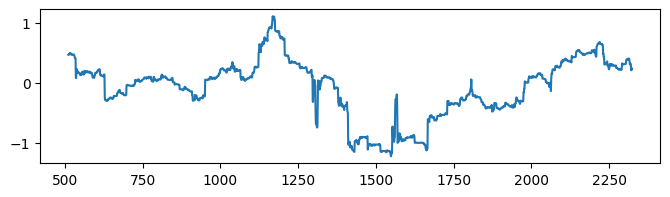

In [ ]:
plt.figure(figsize=(8,2))
alldatacommodities_df[alldatacommodities_df["Ticker"] == "GLD"].rolling_skew.plot()
plt.show()

Assign a weight to each ETF in the asset class based on their skew

In [ ]:
commodities = ["GLD", "SLV", "GSG", "USO", "PPLT", "UNG", "DBA"]
alldatacommodities_df['SkewWeightRaw']=alldatacommodities_df.groupby('Date')['EOM_rolling_skew_lookback'].rank(ascending=False)-(len(commodities)+1)/2
alldatacommodities_df['SkewWeight']=alldatacommodities_df['SkewWeightRaw']/np.sum(np.arange(1, alldatacommodities_df['SkewWeightRaw'].max()+0.1, 1))

Plot skew weight of GLD

<Figure size 800x200 with 0 Axes>

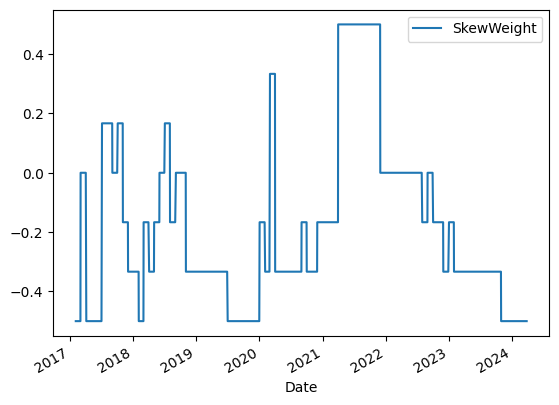

In [ ]:
plt.figure(figsize=(8,2))
alldatacommodities_df[alldatacommodities_df["Ticker"] == "GLD"].plot(x='Date', y='SkewWeight')
plt.show()

Calculate the returns of the skew portfolio and of the market consisting out of the commodity ETFs

<ipython-input-58-d0155b3a514d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldatacommodities_df['ReturnIndividual'] = groupings.transform(lambda x: x)
<ipython-input-58-d0155b3a514d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldatacommodities_df['PortfolioReturn'] = groupings.transform(lambda x: x)


<function matplotlib.pyplot.show(close=None, block=None)>

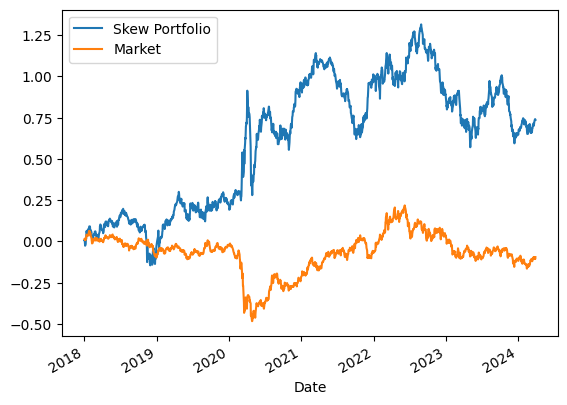

In [ ]:
alldatacommodities_df['WeightxLogret']=(alldatacommodities_df['SkewWeight']*alldatacommodities_df['ret'])
alldatacommodities_df = alldatacommodities_df[alldatacommodities_df["Date"] >= "2018-01-01"]
groupings = alldatacommodities_df.groupby(['Ticker'],group_keys=False)['WeightxLogret'].cumsum()
alldatacommodities_df['ReturnIndividual'] = groupings.transform(lambda x: x)
groupings = alldatacommodities_df.groupby(['Date'],group_keys=False)['ReturnIndividual'].sum()
alldatacommodities_df['PortfolioReturn'] = groupings.transform(lambda x: x)
alldatacommodities_df.tail(50)
groupings = alldatacommodities_df.groupby(['Date'],group_keys=False)['ReturnIndividual'].sum()
PortfolioReturnsCommodities = groupings.transform(lambda x: x)
PortfolioReturnsCommodities.plot()

groupings = alldatacommodities_df.groupby(['Ticker'],group_keys=False)['ret'].cumsum()
alldatacommodities_df['MarketReturnIndividual'] = groupings.transform(lambda x: x)

groupings = alldatacommodities_df.groupby(['Date'],group_keys=False)['MarketReturnIndividual'].sum()
MarketReturnsCommodities = groupings.transform(lambda x: x)
MarketReturnsCommodities = MarketReturnsCommodities/len(commodities)
MarketReturnsCommodities.plot()

plt.gca().legend(('Skew Portfolio','Market'))
plt.show

Can see that skew portfolio outperforms the market during the testing period

Perform OLS regression to determine alpha and market beta (and their respective p values).

In [ ]:
MarketReturnsCommodities1 = sm.add_constant(MarketReturnsCommodities)

result = sm.OLS(PortfolioReturnsCommodities, MarketReturnsCommodities1).fit()

# printing the summary table
print(result.summary())
result.params

                            OLS Regression Results                            
Dep. Variable:       ReturnIndividual   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8679
Date:                Thu, 23 May 2024   Prob (F-statistic):              0.352
Time:                        21:37:59   Log-Likelihood:                -726.59
No. Observations:                1570   AIC:                             1457.
Df Residuals:                    1568   BIC:                             1468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

const                     0.619366
MarketReturnIndividual    0.074890
dtype: float64

In [ ]:
linregress(MarketReturnsCommodities,PortfolioReturnsCommodities)

LinregressResult(slope=0.07488976611078871, intercept=0.6193664390096213, rvalue=0.023519989023177576, pvalue=0.3516857861382099, stderr=0.0803881757735674, intercept_stderr=0.011142394715860414)

# Repeat process for Equity ETFs

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

<function matplotlib.pyplot.show(close=None, block=None)>

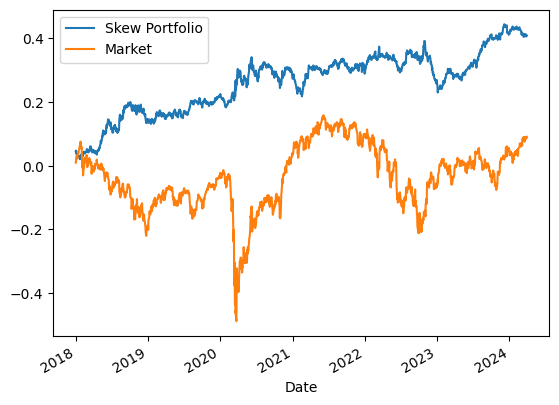

In [ ]:
equity = ["SPY", "EWU", "EWJ", "INDA", "EWG", "EWL", "EWP", "EWQ",
                        "VTI", "FXI", "EWZ", "EWY", "EWA", "EWC", "EWG",
                        "EWH", "EWI", "EWN", "EWD", "EWT", "EZA", "EWW", "ENOR", "EDEN", "TUR"]

alldataequity  = []
for j in equity:
  individualdf =  get_data(j,startdate,enddate)
  individualdf
  individualdf = individualdf.drop(columns=['Open','High','Low','Adj Close','Volume'])
  individualdf['pct_change'] = individualdf.Close.pct_change()
  individualdf['ret'] = np.log(individualdf.Close) - np.log(individualdf.Close.shift(1))
  individualdf['rolling_mean'] = individualdf.ret.rolling(256).mean()
  individualdf['rolling_std'] = individualdf.ret.rolling(256).std()
  individualdf['skew_day'] = ((individualdf.ret-individualdf.rolling_mean)/individualdf.rolling_std)**3
  individualdf['rolling_skew'] = individualdf.skew_day.rolling(256).mean()
  individualdf = individualdf.reset_index()
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['Date']
  individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False).max()
  individualdf['EOM'] = groupings.transform(lambda x: x.max())
  individualdf['EOM_rolling_skew'] = groupings.transform(lambda x: individualdf[individualdf["Date"] == x.max()].rolling_skew)
  individualdf['EOM_rolling_skew_lookback'] = individualdf.EOM_rolling_skew.shift(1)
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['EOM_rolling_skew']
  individualdf['EOM_rolling_skew'] = groupings.transform(lambda x: x.max())
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['EOM_rolling_skew_lookback']
  individualdf['EOM_rolling_skew_lookback'] = groupings.transform(lambda x: x.max())

  alldataequity.append(individualdf)

#alldataequity

alldataequity_df = pd.concat(alldataequity)

alldataequity_df['SkewWeightRaw']=alldataequity_df.groupby('Date')['EOM_rolling_skew_lookback'].rank(ascending=False)-(len(equity)+1)/2
alldataequity_df['SkewWeight']=alldataequity_df['SkewWeightRaw']/np.sum(np.arange(1, alldataequity_df['SkewWeightRaw'].max()+0.1, 1))

alldataequity_df['WeightxLogret']=(alldataequity_df['SkewWeight']*alldataequity_df['ret'])
alldataequity_df = alldataequity_df[alldataequity_df["Date"] >= "2018-01-01"]
groupings = alldataequity_df.groupby(['Ticker'],group_keys=False)['WeightxLogret'].cumsum()
alldataequity_df['ReturnIndividual'] = groupings.transform(lambda x: x)
groupings = alldataequity_df.groupby(['Date'],group_keys=False)['ReturnIndividual'].sum()
alldataequity_df['PortfolioReturn'] = groupings.transform(lambda x: x)
alldataequity_df.tail(50)
groupings = alldataequity_df.groupby(['Date'],group_keys=False)['ReturnIndividual'].sum()
PortfolioReturnsEquity = groupings.transform(lambda x: x)
PortfolioReturnsEquity.plot()

groupings = alldataequity_df.groupby(['Ticker'],group_keys=False)['ret'].cumsum()
alldataequity_df['MarketReturnIndividual'] = groupings.transform(lambda x: x)

groupings = alldataequity_df.groupby(['Date'],group_keys=False)['MarketReturnIndividual'].sum()
MarketReturnsEquity = groupings.transform(lambda x: x)
MarketReturnsEquity = MarketReturnsEquity/len(equity)
MarketReturnsEquity.plot()

plt.gca().legend(('Skew Portfolio','Market'))
plt.show

In [ ]:
MarketReturnsEquity1 = sm.add_constant(MarketReturnsEquity)

result = sm.OLS(PortfolioReturnsEquity, MarketReturnsEquity1).fit()

# printing the summary table
print(result.summary())
result.params

                            OLS Regression Results                            
Dep. Variable:       ReturnIndividual   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     95.00
Date:                Thu, 23 May 2024   Prob (F-statistic):           7.82e-22
Time:                        21:38:23   Log-Likelihood:                 1485.6
No. Observations:                1570   AIC:                            -2967.
Df Residuals:                    1568   BIC:                            -2956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

const                     0.269098
MarketReturnIndividual    0.226160
dtype: float64

In [ ]:
linregress(MarketReturnsEquity,PortfolioReturnsEquity)

LinregressResult(slope=0.22616040262392453, intercept=0.26909838683521675, rvalue=0.23901080538747735, pvalue=7.81517219279385e-22, stderr=0.023203462476002936, intercept_stderr=0.0025105150412339113)

# Repeat process for fixed income ETFs

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<function matplotlib.pyplot.show(close=None, block=None)>

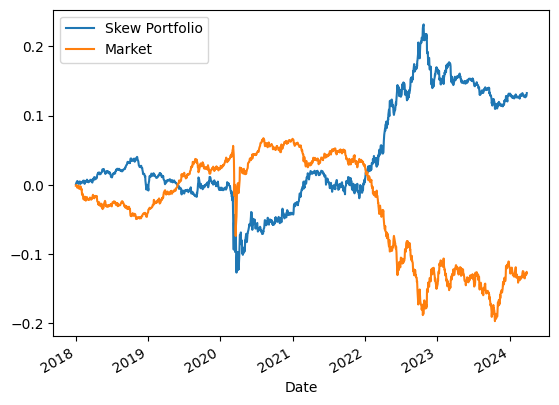

In [ ]:
FI = ["AGG", "TLT", "LQD", "JNK", "MUB", "MBB", "IGOV", "EMB", "BND", "BNDX", "VCIT", "VCSH", "BSV", "SRLN"]

alldataFI  = []
for j in FI:
  individualdf =  get_data(j,startdate,enddate)
  individualdf
  individualdf = individualdf.drop(columns=['Open','High','Low','Adj Close','Volume'])
  individualdf['pct_change'] = individualdf.Close.pct_change()
  individualdf['ret'] = np.log(individualdf.Close) - np.log(individualdf.Close.shift(1))
  individualdf['rolling_mean'] = individualdf.ret.rolling(256).mean()
  individualdf['rolling_std'] = individualdf.ret.rolling(256).std()
  individualdf['skew_day'] = ((individualdf.ret-individualdf.rolling_mean)/individualdf.rolling_std)**3
  individualdf['rolling_skew'] = individualdf.skew_day.rolling(256).mean()
  individualdf = individualdf.reset_index()
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['Date']
  individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False).max()
  individualdf['EOM'] = groupings.transform(lambda x: x.max())
  individualdf['EOM_rolling_skew'] = groupings.transform(lambda x: individualdf[individualdf["Date"] == x.max()].rolling_skew)
  individualdf['EOM_rolling_skew_lookback'] = individualdf.EOM_rolling_skew.shift(1)
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['EOM_rolling_skew']
  individualdf['EOM_rolling_skew'] = groupings.transform(lambda x: x.max())
  groupings = individualdf.groupby([individualdf.Date.dt.year, individualdf.Date.dt.month],group_keys=False)['EOM_rolling_skew_lookback']
  individualdf['EOM_rolling_skew_lookback'] = groupings.transform(lambda x: x.max())

  alldataFI.append(individualdf)

#alldataFI

alldataFI_df = pd.concat(alldataFI)

alldataFI_df['SkewWeightRaw']=alldataFI_df.groupby('Date')['EOM_rolling_skew_lookback'].rank(ascending=False)-(len(FI)+1)/2
alldataFI_df['SkewWeight']=alldataFI_df['SkewWeightRaw']/np.sum(np.arange(1, alldataFI_df['SkewWeightRaw'].max()+0.1, 1))

alldataFI_df['WeightxLogret']=(alldataFI_df['SkewWeight']*alldataFI_df['ret'])
alldataFI_df = alldataFI_df[alldataFI_df["Date"] >= "2018-01-01"]
groupings = alldataFI_df.groupby(['Ticker'],group_keys=False)['WeightxLogret'].cumsum()
alldataFI_df['ReturnIndividual'] = groupings.transform(lambda x: x)
groupings = alldataFI_df.groupby(['Date'],group_keys=False)['ReturnIndividual'].sum()
alldataFI_df['PortfolioReturn'] = groupings.transform(lambda x: x)
alldataFI_df.tail(50)
groupings = alldataFI_df.groupby(['Date'],group_keys=False)['ReturnIndividual'].sum()
PortfolioReturnsFI = groupings.transform(lambda x: x)
PortfolioReturnsFI.plot()

groupings = alldataFI_df.groupby(['Ticker'],group_keys=False)['ret'].cumsum()
alldataFI_df['MarketReturnIndividual'] = groupings.transform(lambda x: x)

groupings = alldataFI_df.groupby(['Date'],group_keys=False)['MarketReturnIndividual'].sum()
MarketReturnsFI = groupings.transform(lambda x: x)
MarketReturnsFI = MarketReturnsFI/len(FI)
MarketReturnsFI.plot()

plt.gca().legend(('Skew Portfolio','Market'))
plt.show

In [ ]:
MarketReturnsFI1 = sm.add_constant(MarketReturnsFI)

result = sm.OLS(PortfolioReturnsFI, MarketReturnsFI1).fit()

# printing the summary table
print(result.summary())
result.params

                            OLS Regression Results                            
Dep. Variable:       ReturnIndividual   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     8596.
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        21:38:28   Log-Likelihood:                 3295.5
No. Observations:                1570   AIC:                            -6587.
Df Residuals:                    1568   BIC:                            -6576.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

const                     0.010537
MarketReturnIndividual   -0.931231
dtype: float64

In [ ]:
linregress(MarketReturnsFI,PortfolioReturnsFI)

LinregressResult(slope=-0.9312311393755575, intercept=0.010536975976605373, rvalue=-0.9196346741533906, pvalue=0.0, stderr=0.010044140312317765, intercept_stderr=0.0008189060526586914)

# Global Skewness Factor Portfolio

Skew portfolios from different assets have low correlation (check) => combine them into one diverse portfolio.

Scale each asset class skew portfolio to have a full sample
volatility of 10% and combine them all on an equal-weight basis.

<function matplotlib.pyplot.show(close=None, block=None)>

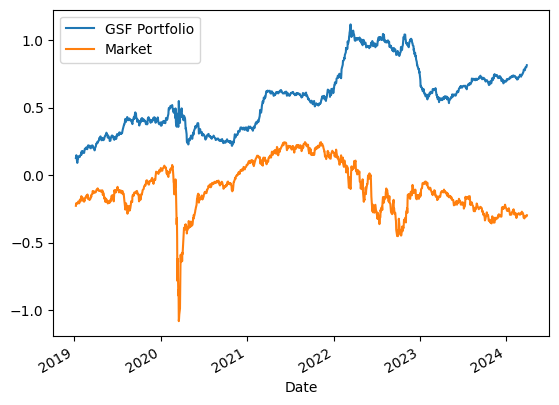

In [ ]:
ReturnsFI_df = PortfolioReturnsFI.to_frame()
ReturnsFI_df["MarketReturnIndividual"] = MarketReturnsFI
ReturnsFI_df["Asset"] = "FI"

ReturnsEquity_df = PortfolioReturnsEquity.to_frame()
ReturnsEquity_df["MarketReturnIndividual"] = MarketReturnsEquity
ReturnsEquity_df["Asset"] = "Equity"

ReturnsCommodities_df = PortfolioReturnsCommodities.to_frame()
ReturnsCommodities_df["MarketReturnIndividual"] = MarketReturnsCommodities
ReturnsCommodities_df["Asset"] = "Commodities"

ReturnsCombined_df = ReturnsCommodities_df._append(ReturnsEquity_df, ignore_index=False)
ReturnsCombined_df = ReturnsCombined_df._append(ReturnsFI_df, ignore_index=False)

ReturnsCombined_df = ReturnsCombined_df.reset_index()
ReturnsCombined_df


groupings = ReturnsCombined_df.groupby(['Asset'],group_keys=False)['ReturnIndividual']
ReturnsCombined_df['Std'] = groupings.transform(lambda x: x.rolling(256).std())
ReturnsCombined_df['NormReturnIndividual'] = 0.1*ReturnsCombined_df.ReturnIndividual/ReturnsCombined_df.Std
ReturnsCombined_df['NormMarketReturnIndividual'] = 0.1*ReturnsCombined_df.MarketReturnIndividual/ReturnsCombined_df.Std
ReturnsCombined_df

groupings = ReturnsCombined_df.groupby(['Date'],group_keys=False)['NormReturnIndividual'].mean()
GSF_Portfolio = groupings.transform(lambda x: x)
groupings = ReturnsCombined_df.groupby(['Date'],group_keys=False)['NormMarketReturnIndividual'].mean()
GSF_Market = groupings.transform(lambda x: x)
GSF_Portfolio.plot()
GSF_Market.plot()

plt.gca().legend(('GSF Portfolio','Market'))
plt.show

In [ ]:
GSF_Market.dropna()
GSF_Market.dropna()

GSF_Market1 = sm.add_constant(GSF_Market)

result = sm.OLS(GSF_Portfolio.dropna(), GSF_Market1.dropna()).fit()

# printing the summary table
print(result.summary())
result.params

                             OLS Regression Results                             
Dep. Variable:     NormReturnIndividual   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.005
Method:                   Least Squares   F-statistic:                     7.958
Date:                  Thu, 23 May 2024   Prob (F-statistic):            0.00486
Time:                          21:38:29   Log-Likelihood:                 4.0825
No. Observations:                  1315   AIC:                            -4.165
Df Residuals:                      1313   BIC:                             6.198
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


const                         0.555588
NormMarketReturnIndividual   -0.100035
dtype: float64

TODO: Check if skew is providing new information that is not available from Value, Momentum, and Carry Factors

For equity ETFs simple to check via value/momentum/carry ETFs